In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

# Make a model with some selected features

In [2]:
all_features = pd.read_csv('derivatives/features.csv')
all_features = all_features.assign(sex_num = lambda df_: df_.sex.astype('category').cat.codes)

train = all_features.query("is_train")

# select whatever features you want
selected_features = ['frontalpole', 'insula', 'sex_num', 'age',
     'internalizing_mcelroy_harmonized_all_samples','externalizing_mcelroy_harmonized_all_samples', 'attention_mcelroy_harmonized_all_samples']

# make sure p_factor is the last columns
train_vars = train[selected_features+['p_factor']]
# Import the LinearRegression type:
from sklearn.linear_model import LinearRegression
# LinearRegression requires a matrix whose columns are the variables and whose
# final column is the value being predicted (the p_factor for us). We can
# extract these columns straight from the dataframes we generated.
train_matrix = train_vars.values
# We need to exclude rows with NaNs for training:
train_okrows = np.all(~np.isnan(train_matrix), axis=1)
train_matrix = train_matrix[train_okrows]
# Train the regression using the training matrix:
lreg = LinearRegression()
## the first argument should be a matrix with all independent variables, the second argument is just the dependent variable (p_factor)
lreg.fit(train_matrix[:, :-1], train_matrix[:, -1])
# Display the trained regression parameters:
print("Linear Regression:")
print("  Intercept:", lreg.intercept_)
print("  Slope:", lreg.coef_)

Linear Regression:
  Intercept: -0.1928839684629871
  Slope: [-3.26295482e-04 -7.78492889e-05  1.00735082e-01  5.05912236e-02
  1.56608715e-01  1.66604373e-01  1.09134812e-01]


# Step 2, predict p_factors

In [3]:
# We can apply the trained linear regression object `lreg` to the 1-column
# matrix of ba1_surface_area values in the test_vars dataframe.
test = all_features.query("not is_train")

# remove subjects with missing values!
test = test.loc[:, selected_features  + ['subject_id']].dropna()

test_matrix = test.loc[:, selected_features].values
test_okrows = np.all(~np.isnan(test_matrix), axis=1)
test_matrix = test_matrix[test_okrows]
# Apply the model:
p_factor_predictions = lreg.predict(test_matrix)
# Display the predictions:
p_factor_predictions

array([-0.30360658, -0.969414  ,  0.31221589, -0.45371466,  0.0399214 ,
       -0.502388  , -0.42456724, -0.33665134, -0.92076446, -0.37029047,
       -0.24603552, -0.01222177, -0.29766459, -0.78452098, -0.59688223,
       -0.14689261, -0.39826318, -0.84550078, -0.72390608, -0.46035806,
       -0.7350664 ,  0.08211346, -0.90128309,  0.05984256,  0.04896632,
       -0.15432427, -0.38992444, -0.29000443, -0.48081778, -0.88404854,
       -0.22247465, -0.21025516, -0.66831231, -0.88929547, -0.24906538,
       -0.40851094, -0.84649663, -0.0292612 , -0.75670648, -0.54236807,
       -0.48237086, -0.28525764, -0.20605646, -0.73145974, -0.45607687,
       -0.46998644, -0.35353482, -0.18367031, -0.40471803, -0.78266856,
       -0.55084729,  0.12678766, -0.64193141, -0.42681566, -0.69402252,
       -0.3690097 , -0.46515487, -0.54253069, -0.14672508, -0.28746823,
       -0.53002118, -0.62191567, -0.45029618, -0.1403265 , -0.18612738,
       -0.46880857, -0.64321208, -0.28439592, -0.72139207, -0.68

In [4]:
# save to a df
test['predicted_p_factor'] = p_factor_predictions
prediction_df = test[['subject_id', 'predicted_p_factor']]
prediction_df

,subject_id,predicted_p_factor
1060,sub-1000881804,-0.303607
1061,sub-100527940,-0.969414
1062,sub-1006151876,0.312216
1063,sub-1012530688,-0.453715
1064,sub-1030193285,0.039921
...,...,...
1587,sub-969649154,-0.426499
1588,sub-970890500,0.277319
1589,sub-975856179,-0.562780
1590,sub-984757368,-0.291787


<Axes: >

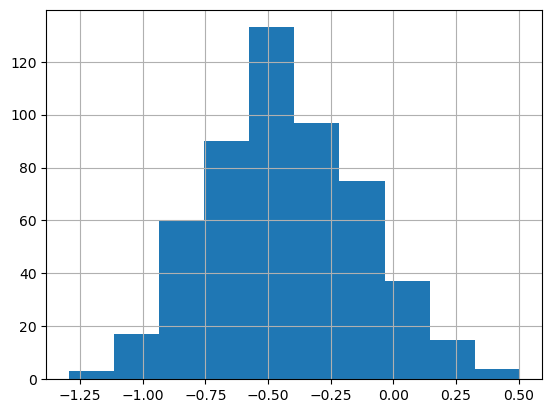

In [5]:
prediction_df['predicted_p_factor'].hist()

In [6]:
prediction_df.to_csv("results/predicted_p_factor.csv", index=False)